In [4]:
# Package Imports
import os
import time
import warnings

import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

from recommenders.utils.timer import Timer
from recommenders.models.deeprec.deeprec_utils import prepare_hparams
from recommenders.models.deeprec.io.sequential_iterator import SequentialIterator

# Local Imports 
from utils import create_vocab
from model import SLI_RECModel_Custom as SeqModel

In [5]:
# DATA_PATH = "/ssd003/projects/aieng/public/recsys_datasets/amazon"
DATA_PATH = Path(f'./Data/kasandr')

BASE_LOG_PATH = "logs"
BASE_MODEL_PATH = "models"
REVIEWS_FILE = 'reviews_Movies_and_TV_5.json'
META_FILE = 'meta_Movies_and_TV.json'

YAML_PATH = "config/sli_rec.yaml"


EPOCHS = 10
BATCH_SIZE = 400
RANDOM_SEED = 42

train_num_ngs = 4
valid_num_ngs = 4

In [6]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# Directories to store train, validation and test splits
train_path = os.path.join(DATA_PATH, r'train_data')
valid_path = os.path.join(DATA_PATH, r'valid_data')
test_path = os.path.join(DATA_PATH, r'test_data')

# Files paths to store the list of existing ids for user, item and item category 
user_vocab_path = os.path.join(DATA_PATH, r'user_vocab.pkl')
item_vocab_path = os.path.join(DATA_PATH, r'item_vocab.pkl')
cate_vocab_path = os.path.join(DATA_PATH, r'category_vocab.pkl')
output_file_path = os.path.join(DATA_PATH, r'output.txt')

# File paths to store reviews and associated metadata
reviews_path = os.path.join(DATA_PATH, REVIEWS_FILE)
meta_path = os.path.join(DATA_PATH, META_FILE)

valid_num_ngs = 4 # number of negative instances with a positive instance for validation
test_num_ngs = 9 # number of negative instances with a positive instance for testing

# create run drectory to store results
if os.path.exists(BASE_MODEL_PATH) == False:
    os.mkdir(BASE_MODEL_PATH)
    
MODEL_PATH = f"{BASE_MODEL_PATH}/{str(time.time())}"

if os.path.exists(BASE_LOG_PATH) == False:
    os.mkdir(BASE_LOG_PATH)

LOG_PATH = f"{BASE_LOG_PATH}/{str(time.time())}"

## Data Loading 

Given that the data is preprocessed in the [amazon_preprocessing notebook](amazon_preprocessing.ipynb), no further processing is required. In this section, we will briefly analyze the train, validation and test sets to get aquainted with the data we will be modelling. Futhermore, a data loader will be defined to iteratively fetch samples from the datasets during training and evaluation. 

The train dataset consists of a dataframe where each record is a review of a product `item_id` in category `cate_id` at time `timestamp` by user `user_id`. Each record also contains the list of previous items the user interacted with `prev_ids` along with the corresponding categories `prev_cate_ids` and timestamps `prev_timestamps`.

In [8]:
train_df = pd.read_csv(train_path, sep="\t", index_col=False, names=["label", "user_id", "item_id", "cate_id", "timestamp", "prev_item_ids", "prev_cate_ids", "prev_timestamps"])
train_df

,label,user_id,item_id,cate_id,timestamp,prev_item_ids,prev_cate_ids,prev_timestamps
0,1,0053b8d4cc3ffb98201781e8d2ac7f668513248f5d5d51...,cdca1333b6820ab29501f879d8dae7c9,Other,1464867431,cdca1333b6820ab29501f879d8dae7c9,Other,1464807455
1,1,0053b8d4cc3ffb98201781e8d2ac7f668513248f5d5d51...,cdca1333b6820ab29501f879d8dae7c9,Other,1464867447,"cdca1333b6820ab29501f879d8dae7c9,cdca1333b6820...","Other,Other","1464807455,1464867431"
2,1,0053b8d4cc3ffb98201781e8d2ac7f668513248f5d5d51...,cdca1333b6820ab29501f879d8dae7c9,Other,1464867528,"cdca1333b6820ab29501f879d8dae7c9,cdca1333b6820...","Other,Other,Other","1464807455,1464867431,1464867447"
3,1,0053b8d4cc3ffb98201781e8d2ac7f668513248f5d5d51...,cdca1333b6820ab29501f879d8dae7c9,Other,1464867577,"cdca1333b6820ab29501f879d8dae7c9,cdca1333b6820...","Other,Other,Other,Other","1464807455,1464867431,1464867447,1464867528"
4,1,0053b8d4cc3ffb98201781e8d2ac7f668513248f5d5d51...,cdca1333b6820ab29501f879d8dae7c9,Other,1464867922,"cdca1333b6820ab29501f879d8dae7c9,cdca1333b6820...","Other,Other,Other,Other,Other","1464807455,1464867431,1464867447,1464867528,14..."
...,...,...,...,...,...,...,...,...
23822,1,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,c15ed4a6bcf39c880f56d03fe1aec56a,Other,1464876998,162decae9179e5b628166ffafca22ab1,Other,1464807808
23823,1,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,75f9aa1430b0e847acb3040e7207784f,Other,1464983603,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other","1464807808,1464876998"
23824,1,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,0e314aac8bb3e8b47cb665a4a62009d1,Other,1464983618,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other","1464807808,1464876998,1464983603"
23825,1,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,131c583fddb7f37a3172f01867d8c48d,Other,1465394490,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618"


The validation and test datasets share the schema as the train dataset. Positive samples are interactions between users and items that have occured. Alternatively, negative samples are interactions between users and items that have not occured. In addition to being used in the training phase, negative samples are included in the validation and test sets so we can compute metrics of how well the generated recommendations approximate the users actual behaviour. 

In [9]:
# Visualize validation dataset dataframe
valid_df = pd.read_csv(valid_path, sep="\t", index_col=False, names=["label", "user_id", "item_id", "cate_id", "timestamp", "prev_item_ids", "prev_cate_ids", "prev_timestamps"])
valid_df

,label,user_id,item_id,cate_id,timestamp,prev_item_ids,prev_cate_ids,prev_timestamps
0,1,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,a5e01c7b865e0ae92bd78ad6db1d1576,Other,1464943154,b203435e0ca71f90508403e762d3a42f,Other,1464850748
1,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,5a6a0ad75329c2721d7273cf8cbb7b63,Other,1464943154,b203435e0ca71f90508403e762d3a42f,Other,1464850748
2,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,d1b4365db02dd693661e0186dbfcc2e7,Other,1464943154,b203435e0ca71f90508403e762d3a42f,Other,1464850748
3,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,7b77553a80a31ccf5d0fe2a387748575,Other,1464943154,b203435e0ca71f90508403e762d3a42f,Other,1464850748
4,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,0f2fcf95319f5c1e5745371351f521e5,Other,1464943154,b203435e0ca71f90508403e762d3a42f,Other,1464850748
...,...,...,...,...,...,...,...,...
12065,1,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,d37111749fe898b02f86688363a4598b,Other,1465397402,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."
12066,0,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,0fc06555404935b0bc18407da4c143b5,Other,1465397402,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."
12067,0,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,a5fc37404646ac3d34118489cdbfb341,Other,1465397402,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."
12068,0,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,eb0389774fca117ee06c5c02a6ba76af,Other,1465397402,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."


In [10]:
# Visualize test dataset dataframe
test_df = pd.read_csv(test_path, sep="\t", index_col=False, names=["label", "user_id", "item_id", "cate_id", "timestamp", "prev_item_ids", "prev_cate_ids", "prev_timestamps"])
test_df

,label,user_id,item_id,cate_id,timestamp,prev_item_ids,prev_cate_ids,prev_timestamps
0,1,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,bf0ddbcb5fcb316d0a2f6f3655b27b91,Other,1464943300,"b203435e0ca71f90508403e762d3a42f,a5e01c7b865e0...","Other,Other","1464850748,1464943154"
1,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,5a6a0ad75329c2721d7273cf8cbb7b63,Other,1464943300,"b203435e0ca71f90508403e762d3a42f,a5e01c7b865e0...","Other,Other","1464850748,1464943154"
2,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,de5795e6274c9538b6afe3d98112611d,Other,1464943300,"b203435e0ca71f90508403e762d3a42f,a5e01c7b865e0...","Other,Other","1464850748,1464943154"
3,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,e9d41bf5aeba0591ef080d3513375338,Other,1464943300,"b203435e0ca71f90508403e762d3a42f,a5e01c7b865e0...","Other,Other","1464850748,1464943154"
4,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,eb0389774fca117ee06c5c02a6ba76af,Other,1464943300,"b203435e0ca71f90508403e762d3a42f,a5e01c7b865e0...","Other,Other","1464850748,1464943154"
...,...,...,...,...,...,...,...,...
28125,0,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,0f2fcf95319f5c1e5745371351f521e5,Other,1465626127,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."
28126,0,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,04ab0460f36b12d22fd4321eaa9b39cb,Other,1465626127,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."
28127,0,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,162decae9179e5b628166ffafca22ab1,Other,1465626127,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."
28128,0,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,2a21cb8865da59cc4845d822c6923ada,Other,1465626127,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."


When training and evaluating neural network models, we typically feed batches of input into the model to generate predictions. This involves iterively sampling batches of data in the dataset . The [microsoft recommenders](https://github.com/microsoft/recommenders) package provides the `SequentialIterator` class which acts as a dataloader for sequential recommender systems such as SLi-Rec. 

In [11]:
input_creator = SequentialIterator

Following the definition of the Sequential Dataset, we need to generate the user, item and category files using the `utils.create_vocab` function. These files contain the unique ids of each user, item and category in the dataset, respectively. This is leveraged by the model to generate embedding tables of the proper dimension. 

In [12]:
create_vocab(train_path, user_vocab_path, item_vocab_path, cate_vocab_path)

## Model Definition

With the sequential dataset in place, we can turn our attention to defining the SLi-Rec model. The [microsoft recommenders](https://github.com/microsoft/recommenders) package provides a variety of recommender methods including SLi-Rec. It provides a uniform interface for both sequential and non-sequential recommender system methods. 

The first step to defining a model is generating the hyperameters `hparams` using the `recommenders.models.deeprec.deeprec_utils.prepare_hparams` function. This function takes a varitey of arguments including model, log save paths and vocabulary file paths along with hyperparameters such as batch size and epochs. The majority of hyperparameters are started in a yaml path at `YAML_PATH`. The microsoft recommenders package provides a [yaml file](https://github.com/microsoft/recommenders/tree/main/recommenders/models/deeprec/config) with default hyperparameters for each of the sequential architectures it supports. There a four types of hyperparameters that are stored in the yaml file: **data**, **model**, **train** and **info**. Below we list a few of the prominent hyperparameters for each type. 

#### Data Hyperparameters
- **user_vocab**: The map file of user to id
- **item_vocab**: The map file of item to id
- **cate_vocab**: The map file of category to id

#### Model Hyperparameters
- **method**: classification or regression
- **layer_sizes**: Number of nodes per layer of DNN
- **activation**: Activation function per layer of DNN
- **dropout**: Dropout proportion per layer of DNN

#### Train Hyperparameters
- **loss**: The data loss to use (pointwise: log_loss, cross_entropy_loss, square_loss  pairwise: softmax)
- **optimizer**: The optimizer to use during training (adam, adadelta, sgd, ftrl, gd, padagrad, pgd, rmsprop)
- **batch_size**:  The number of samples per batch
- **epochs**: The number of times to iterate through the training set
- **train_num_ngs**: The number of negative instances to include per postive instance in training set 
- **learning_rate**: Determines the step size of updates to model parameters

#### Info Hyperparameters
- **save_model**: Whether or not to save model 
- **save_epoch**: Frequency in which model is saved 
- **metrics**: Metrics for evaluation

In [13]:
hparams = prepare_hparams(YAML_PATH, 
                          embed_l2=0., 
                          layer_l2=0., 
                          learning_rate=0.001,  # set to 0.01 if batch normalization is disable
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          metrics=['auc'] ,
                          pairwise_metrics=['ndcg@1;3;5','hit@1;3;5', "group_auc"],
                          show_step=20,
                          MODEL_DIR=os.path.join(MODEL_PATH),
                          SUMMARIES_DIR=os.path.join(LOG_PATH),
                          user_vocab=user_vocab_path,
                          item_vocab=item_vocab_path,
                          cate_vocab=cate_vocab_path,
                          need_sample=True,
                          train_num_ngs=train_num_ngs, # provides the number of negative instances for each positive instance for loss computation.
            )

To define the model, we pass the hyperparameters, sequential dataset and seed to the `models.SLI_RECModel_Custom` constructor. The `models.SLI_RECModel_Custom` class is a simple extension of the `recommenders.models.deeprec.models.sequential.sli_rec.SLI_RECModel` that overrides the `fit` method to more easily access train and evaluation metrics accross epochs. This is done as a convenience and is by no means required by package. 

In [14]:
model = SeqModel(hparams, input_creator, seed=RANDOM_SEED)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Colocations handled automatically by placer.


/ssd003/projects/aieng/public/recsys/lib/python3.7/site-packages/recommenders/models/deeprec/models/base_model.py:705: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  training=self.is_train_stage,
Instructions for updating:
Colocations handled automatically by placer.


## Training and Validation

The next step is to train and validated the model we defined using the training and validation set we previously generated using the `model.fit` method. This method trains and validates the model for a number of epochs and returns the updated model along with the train and validation results. 

In [15]:
with Timer() as train_time:
    model, train_info, eval_info = model.fit(train_path, valid_path, valid_num_ngs=valid_num_ngs) 

# valid_num_ngs is the number of negative lines after each positive line in your valid_file 
# we will evaluate the performance of model on valid_file every epoch
print('Time cost for training is {0:.2f} mins'.format(train_time.interval/60.0))

step 20 , total_loss: 1.2761, data_loss: 1.2761
step 40 , total_loss: 0.8877, data_loss: 0.8877
step 60 , total_loss: 0.6847, data_loss: 0.6847
eval valid at epoch 1: auc:0.7695,ndcg@1:0.4457,ndcg@3:0.7338,ndcg@5:0.7613,hit@1:0.4457,hit@3:0.9354,hit@5:1.0,group_auc:0.7878
INFO:tensorflow:models/1675338286.3663678epoch_1.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678epoch_1.data-00000-of-00001


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675338286.3663678epoch_1.meta


INFO:tensorflow:models/1675338286.3663678epoch_1.meta


INFO:tensorflow:2400


INFO:tensorflow:2400


INFO:tensorflow:models/1675338286.3663678epoch_1.index


INFO:tensorflow:models/1675338286.3663678epoch_1.index


INFO:tensorflow:2400


INFO:tensorflow:2400


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:0


INFO:tensorflow:0


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:2400


INFO:tensorflow:2400


step 20 , total_loss: 0.6561, data_loss: 0.6561
step 40 , total_loss: 0.6272, data_loss: 0.6272
step 60 , total_loss: 0.4643, data_loss: 0.4643
eval valid at epoch 2: auc:0.8832,ndcg@1:0.6897,ndcg@3:0.8689,ndcg@5:0.8739,hit@1:0.6897,hit@3:0.9884,hit@5:1.0,group_auc:0.8991
INFO:tensorflow:models/1675338286.3663678epoch_2.meta


INFO:tensorflow:models/1675338286.3663678epoch_2.meta


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678epoch_2.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678epoch_2.data-00000-of-00001


INFO:tensorflow:2400


INFO:tensorflow:2400


INFO:tensorflow:models/1675338286.3663678epoch_2.index


INFO:tensorflow:models/1675338286.3663678epoch_2.index


INFO:tensorflow:2400


INFO:tensorflow:2400


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:0


INFO:tensorflow:0


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:2400


INFO:tensorflow:2400


step 20 , total_loss: 0.5287, data_loss: 0.5287
step 40 , total_loss: 0.4753, data_loss: 0.4753
step 60 , total_loss: 0.5173, data_loss: 0.5173
eval valid at epoch 3: auc:0.9302,ndcg@1:0.7755,ndcg@3:0.9082,ndcg@5:0.9107,hit@1:0.7755,hit@3:0.9942,hit@5:1.0,group_auc:0.9311
INFO:tensorflow:models/1675338286.3663678epoch_3.meta


INFO:tensorflow:models/1675338286.3663678epoch_3.meta


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678epoch_3.index


INFO:tensorflow:models/1675338286.3663678epoch_3.index


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678epoch_3.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678epoch_3.data-00000-of-00001


INFO:tensorflow:2400


INFO:tensorflow:2400


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:0


INFO:tensorflow:0


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:2400


INFO:tensorflow:2400


step 20 , total_loss: 0.4966, data_loss: 0.4966
step 40 , total_loss: 0.5072, data_loss: 0.5072
step 60 , total_loss: 0.4707, data_loss: 0.4707
eval valid at epoch 4: auc:0.9337,ndcg@1:0.7693,ndcg@3:0.9035,ndcg@5:0.9078,hit@1:0.7693,hit@3:0.9901,hit@5:1.0,group_auc:0.9277
step 20 , total_loss: 0.4772, data_loss: 0.4772
step 40 , total_loss: 0.4056, data_loss: 0.4056
step 60 , total_loss: 0.4105, data_loss: 0.4105
eval valid at epoch 5: auc:0.9401,ndcg@1:0.7875,ndcg@3:0.9124,ndcg@5:0.9156,hit@1:0.7875,hit@3:0.9925,hit@5:1.0,group_auc:0.9348
INFO:tensorflow:models/1675338286.3663678epoch_5.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678epoch_5.data-00000-of-00001


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675338286.3663678epoch_5.index


INFO:tensorflow:models/1675338286.3663678epoch_5.index


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675338286.3663678epoch_5.meta


INFO:tensorflow:models/1675338286.3663678epoch_5.meta


INFO:tensorflow:2400


INFO:tensorflow:2400


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:0


INFO:tensorflow:0


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:2400


INFO:tensorflow:2400


step 20 , total_loss: 0.4632, data_loss: 0.4632
step 40 , total_loss: 0.4052, data_loss: 0.4052
step 60 , total_loss: 0.4661, data_loss: 0.4661
eval valid at epoch 6: auc:0.9438,ndcg@1:0.7949,ndcg@3:0.9151,ndcg@5:0.9183,hit@1:0.7949,hit@3:0.9925,hit@5:1.0,group_auc:0.9364
INFO:tensorflow:models/1675338286.3663678epoch_6.meta


INFO:tensorflow:models/1675338286.3663678epoch_6.meta


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678epoch_6.index


INFO:tensorflow:models/1675338286.3663678epoch_6.index


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678epoch_6.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678epoch_6.data-00000-of-00001


INFO:tensorflow:2400


INFO:tensorflow:2400


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:0


INFO:tensorflow:0


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:2400


INFO:tensorflow:2400


step 20 , total_loss: 0.4771, data_loss: 0.4771
step 40 , total_loss: 0.4370, data_loss: 0.4370
step 60 , total_loss: 0.3703, data_loss: 0.3703
eval valid at epoch 7: auc:0.9394,ndcg@1:0.7916,ndcg@3:0.9142,ndcg@5:0.9176,hit@1:0.7916,hit@3:0.9921,hit@5:1.0,group_auc:0.9365
INFO:tensorflow:models/1675338286.3663678epoch_7.index


INFO:tensorflow:models/1675338286.3663678epoch_7.index


INFO:tensorflow:0


INFO:tensorflow:0


INFO:tensorflow:models/1675338286.3663678epoch_7.meta


INFO:tensorflow:models/1675338286.3663678epoch_7.meta


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678epoch_7.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678epoch_7.data-00000-of-00001


INFO:tensorflow:2400


INFO:tensorflow:2400


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:0


INFO:tensorflow:0


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:2400


INFO:tensorflow:2400


step 20 , total_loss: 0.4552, data_loss: 0.4552
step 40 , total_loss: 0.3952, data_loss: 0.3952
step 60 , total_loss: 0.4171, data_loss: 0.4171
eval valid at epoch 8: auc:0.9446,ndcg@1:0.7958,ndcg@3:0.9164,ndcg@5:0.9189,hit@1:0.7958,hit@3:0.9942,hit@5:1.0,group_auc:0.9374
INFO:tensorflow:models/1675338286.3663678epoch_8.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678epoch_8.data-00000-of-00001


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675338286.3663678epoch_8.index


INFO:tensorflow:models/1675338286.3663678epoch_8.index


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675338286.3663678epoch_8.meta


INFO:tensorflow:models/1675338286.3663678epoch_8.meta


INFO:tensorflow:2400


INFO:tensorflow:2400


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:0


INFO:tensorflow:0


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:2400


INFO:tensorflow:2400


step 20 , total_loss: 0.4234, data_loss: 0.4234
step 40 , total_loss: 0.4441, data_loss: 0.4441
step 60 , total_loss: 0.4042, data_loss: 0.4042
eval valid at epoch 9: auc:0.9369,ndcg@1:0.7804,ndcg@3:0.9107,ndcg@5:0.9134,hit@1:0.7804,hit@3:0.9934,hit@5:1.0,group_auc:0.9338
step 20 , total_loss: 0.4226, data_loss: 0.4226
step 40 , total_loss: 0.3950, data_loss: 0.3950
step 60 , total_loss: 0.3294, data_loss: 0.3294
eval valid at epoch 10: auc:0.9492,ndcg@1:0.8045,ndcg@3:0.9208,ndcg@5:0.9232,hit@1:0.8045,hit@3:0.9942,hit@5:1.0,group_auc:0.9417
INFO:tensorflow:models/1675338286.3663678epoch_10.meta


INFO:tensorflow:models/1675338286.3663678epoch_10.meta


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678epoch_10.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678epoch_10.data-00000-of-00001


INFO:tensorflow:2400


INFO:tensorflow:2400


INFO:tensorflow:models/1675338286.3663678epoch_10.index


INFO:tensorflow:models/1675338286.3663678epoch_10.index


INFO:tensorflow:2400


INFO:tensorflow:2400


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:models/1675338286.3663678/best_model.index


INFO:tensorflow:0


INFO:tensorflow:0


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:models/1675338286.3663678/best_model.meta


INFO:tensorflow:1900


INFO:tensorflow:1900


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:models/1675338286.3663678/best_model.data-00000-of-00001


INFO:tensorflow:2400


INFO:tensorflow:2400


[(1, {'auc': 0.7695, 'ndcg@1': 0.4457, 'ndcg@3': 0.7338, 'ndcg@5': 0.7613, 'hit@1': 0.4457, 'hit@3': 0.9354, 'hit@5': 1.0, 'group_auc': 0.7878}), (2, {'auc': 0.8832, 'ndcg@1': 0.6897, 'ndcg@3': 0.8689, 'ndcg@5': 0.8739, 'hit@1': 0.6897, 'hit@3': 0.9884, 'hit@5': 1.0, 'group_auc': 0.8991}), (3, {'auc': 0.9302, 'ndcg@1': 0.7755, 'ndcg@3': 0.9082, 'ndcg@5': 0.9107, 'hit@1': 0.7755, 'hit@3': 0.9942, 'hit@5': 1.0, 'group_auc': 0.9311}), (4, {'auc': 0.9337, 'ndcg@1': 0.7693, 'ndcg@3': 0.9035, 'ndcg@5': 0.9078, 'hit@1': 0.7693, 'hit@3': 0.9901, 'hit@5': 1.0, 'group_auc': 0.9277}), (5, {'auc': 0.9401, 'ndcg@1': 0.7875, 'ndcg@3': 0.9124, 'ndcg@5': 0.9156, 'hit@1': 0.7875, 'hit@3': 0.9925, 'hit@5': 1.0, 'group_auc': 0.9348}), (6, {'auc': 0.9438, 'ndcg@1': 0.7949, 'ndcg@3': 0.9151, 'ndcg@5': 0.9183, 'hit@1': 0.7949, 'hit@3': 0.9925, 'hit@5': 1.0, 'group_auc': 0.9364}), (7, {'auc': 0.9394, 'ndcg@1': 0.7916, 'ndcg@3': 0.9142, 'ndcg@5': 0.9176, 'hit@1': 0.7916, 'hit@3': 0.9921, 'hit@5': 1.0, 'group_

In [16]:
# unpack train and evaluation info
epochs, train_metrics = zip(*train_info)
epochs, eval_metrics = zip(*eval_info)

# Reformat train metrics from list of dicts to dict of lists 
train_column_names = train_metrics[0].keys()
train_metric_dict = {name: [] for name in train_column_names}
for train_metric in train_metrics: 
    for key, val in train_metric.items():
        train_metric_dict[key].append(val)

# Reformat eval metrics from list of dicts to dict of lists 
eval_column_names = eval_metrics[0].keys()
eval_metric_dict = {name: [] for name in eval_column_names}
for eval_metric in eval_metrics:
    for key, val in eval_metric.items():
        eval_metric_dict[key].append(val) 

The train metrics that are logged include: 
- **Loss**: The loss is the summation of the regularization loss and the data loss. The regularization loss penalizes the magnitude of the parameters to avoid overfitting.
- **Data Loss:** The data loss is computed between the rating predicted by the model and the ground truth interactions. This is typically a cross entropy loss for data with implicit feedback and mean squared error loss for explicit feedback.

We can visualize plot these metrics across metrics as follows: 

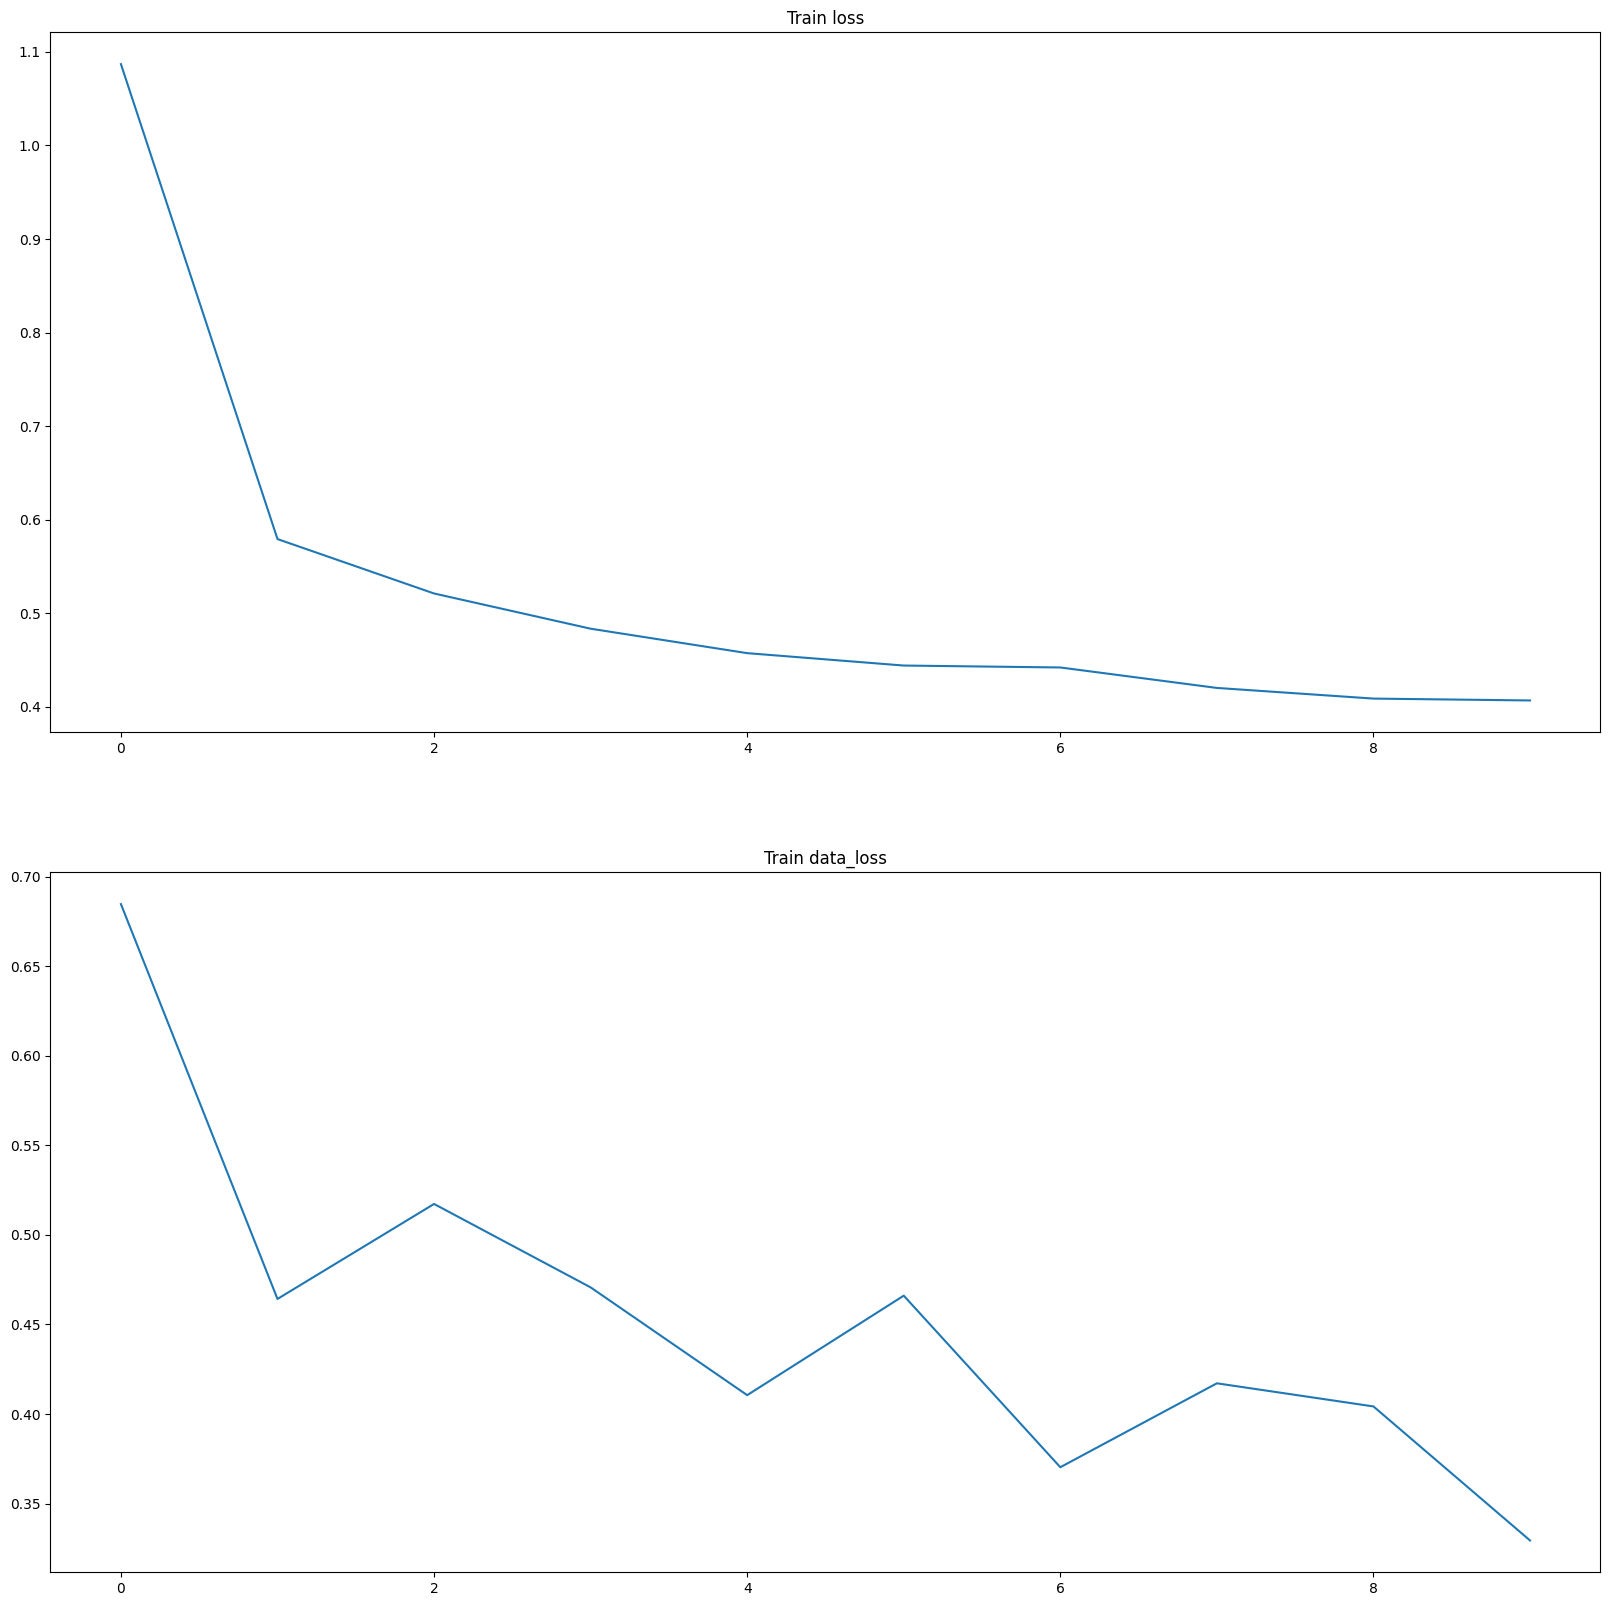

In [17]:
# Visualize train metrics

f, axarr = plt.subplots(len(train_metric_dict.keys()), 1, figsize=(20, 20))

for i, key in enumerate(train_metric_dict.keys()): 
    index = list(range(len(train_metric_dict[key])))
    vals = train_metric_dict[key]
    axarr[i].set_title(f"Train {key}")
    axarr[i].plot(index, vals)

The validation metrics that are logged include: 

#### AUC
AUC measures the likelihood that a random relevant item is ranked higher than a random irrelevant item. AUC is calculated based on the ranks given by the algorithm to all items — out of all possible pairs of type (relevant-item, non-relevant-item), AUC is a proportion of pairs where relevant-item was ranked higher than the irrelevant item from that pair.

<p align="center">
<img width="578" alt="image" src="https://user-images.githubusercontent.com/34798787/182898565-952432f9-38e0-48b9-94fe-85144acec6a6.png">
</p>


#### Normalized discounted cumulative gain (NDCG@K)
NDCG measures the overall reward at all positions that hold a relevant item. The reward is an inverse log of the position (i.e. higher ranks for relevant items would lead to better reward, as desired).

<p align="center">
<img width="578" alt="image" src="https://user-images.githubusercontent.com/34798787/182896608-d0f772dd-22c3-4bd8-80cd-925a954d5197.png">
</p>

The inverse log has a top-heavy property and therefore it’s suitable for evaluating recommendation systems.


<p align="center">
<img width="578" alt="image" src="https://user-images.githubusercontent.com/34798787/182897830-bfdde1e2-1b5f-42c1-9d76-a370ead875d1.png">
</p>

For more information regarding the aforementioned metrics, please refer to this [blog post](https://flowthytensor.medium.com/some-metrics-to-evaluate-recommendation-systems-9e0cf0c8b6cf#:~:text=AUC%20measures%20the%20likelihood%20that,meaning%20a%20better%20recommendation%20system.). 

We can visualize plot these metrics across metrics as follows:

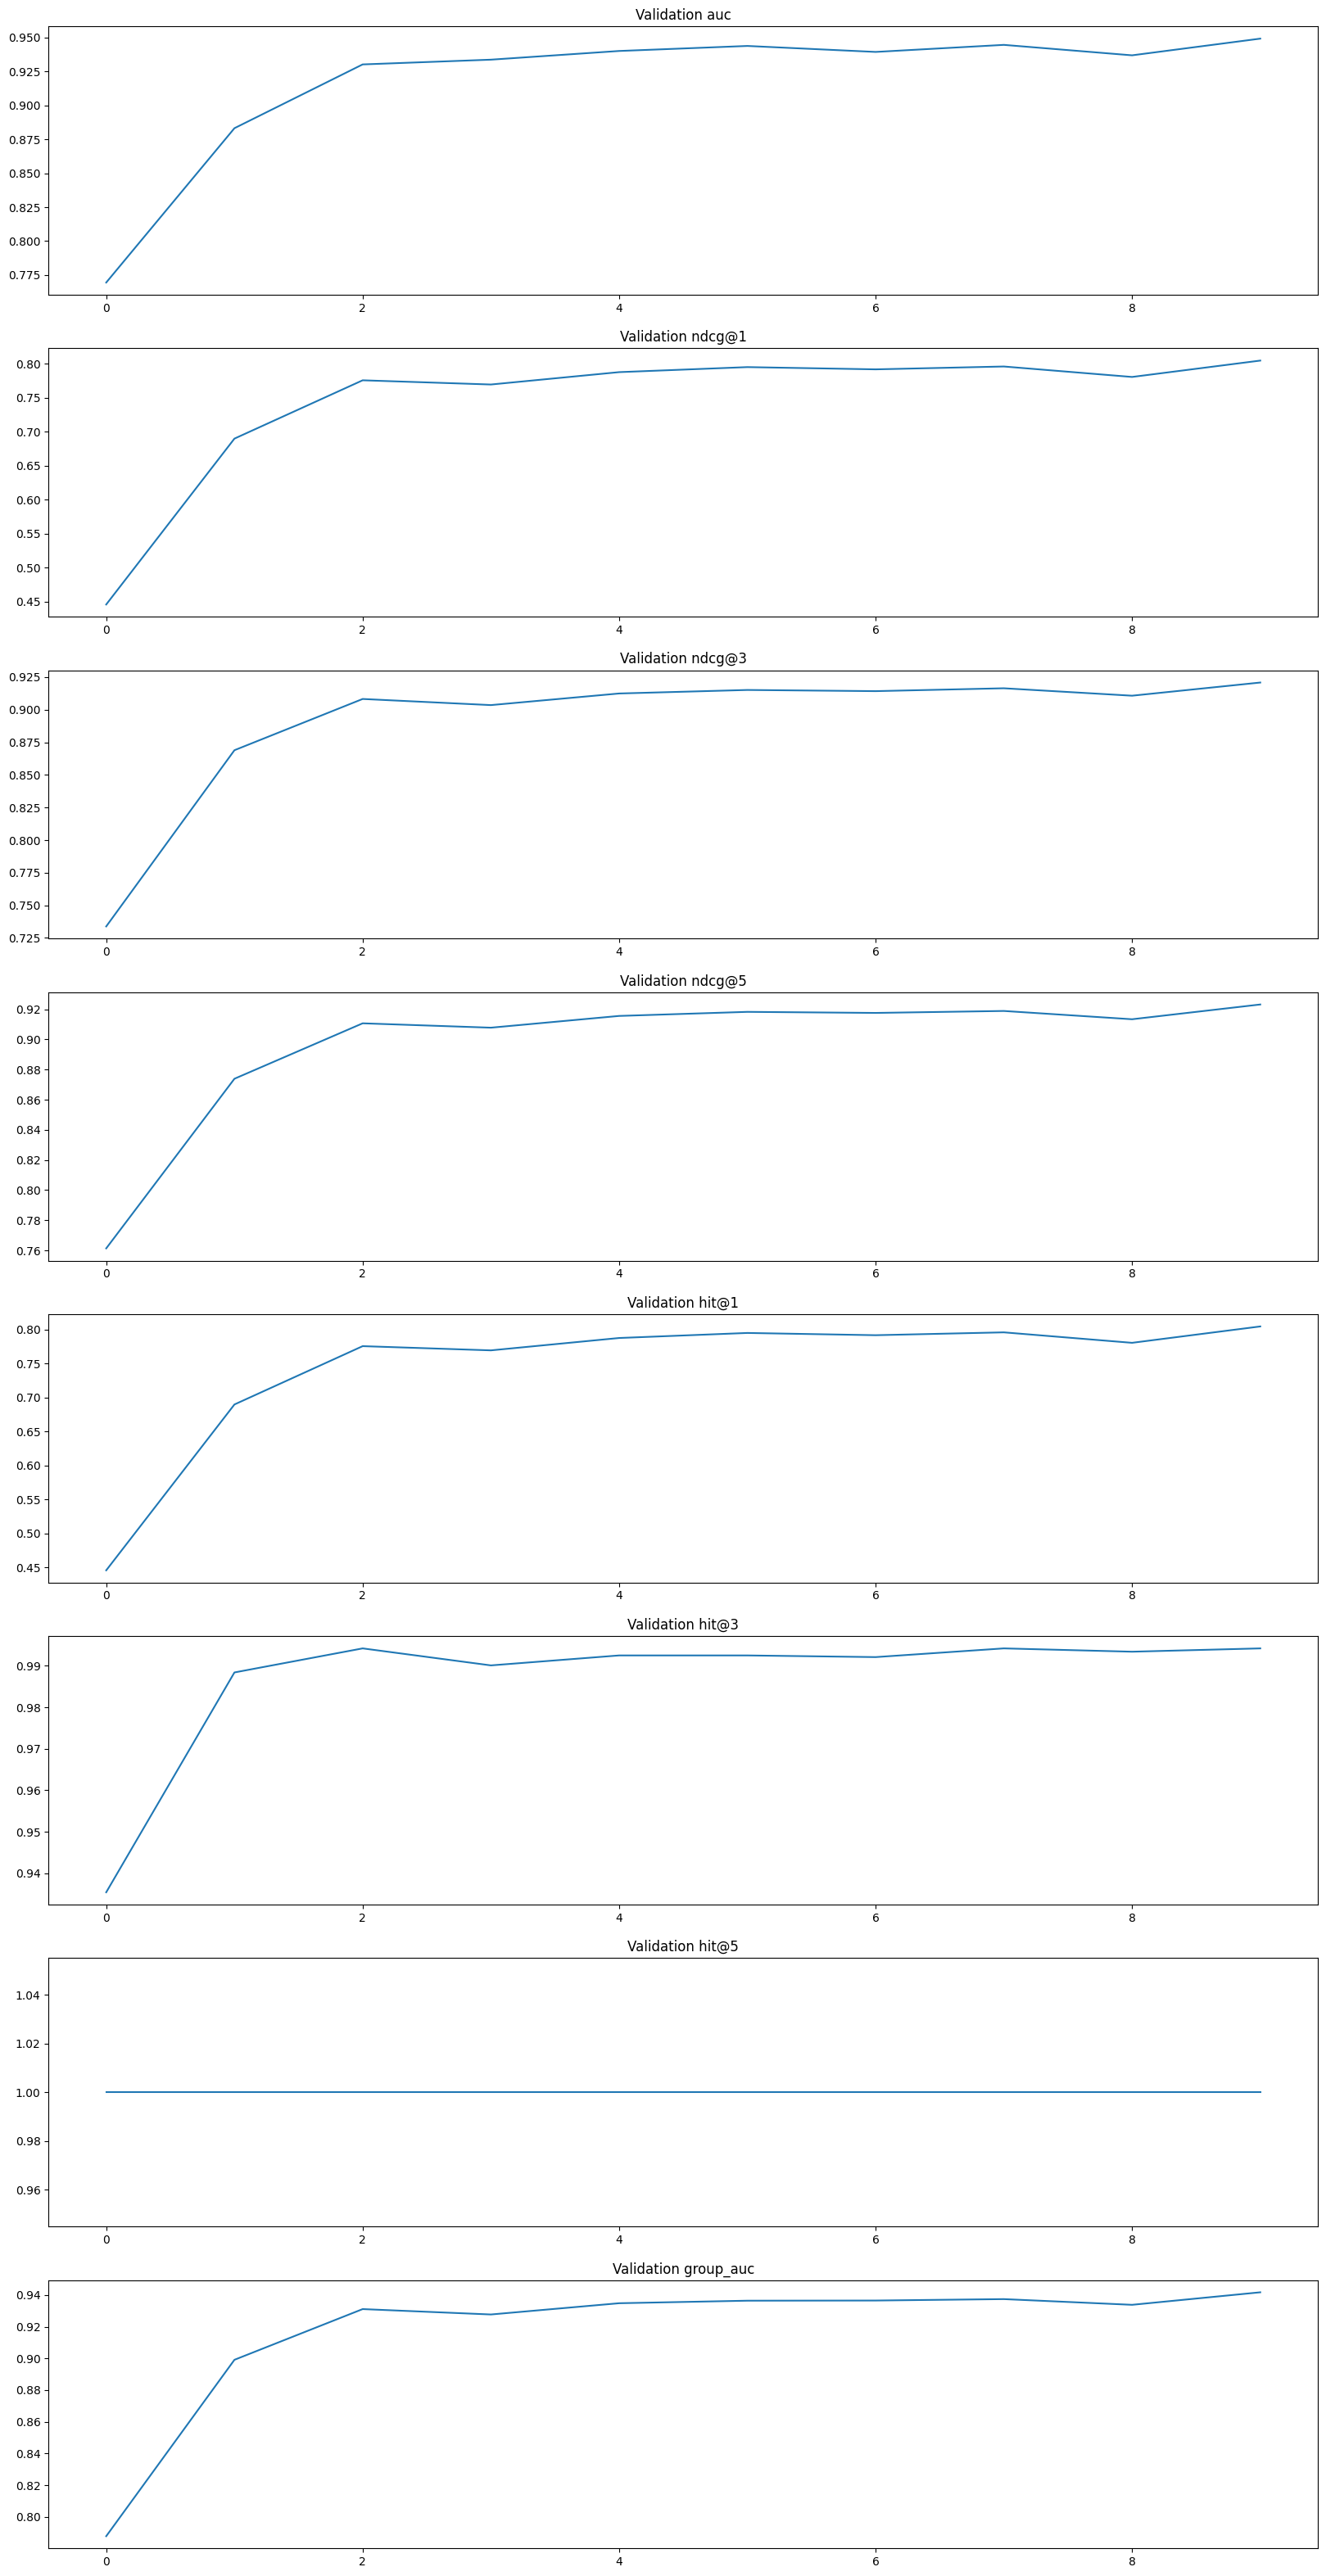

In [18]:
# Visualize eval metrics

f, axarr = plt.subplots(len(eval_metric_dict.keys()), 1, figsize=(20, 40))

for i, key in enumerate(eval_metric_dict.keys()): 
    index = list(range(len(eval_metric_dict[key])))
    vals = eval_metric_dict[key]
    axarr[i].set_title(f"Validation {key}")
    axarr[i].plot(index, vals)

## Testing

Now that are model is trained and validated, the last step is to evaluate the model on the held out test set. During training, the best performing model on the validation set across epochs is automatically saved. The `model.run_eval` method runs the evaluation precedure on the test set located in `test_path` using the best model from the train/validation step and returns the corresponding metrics. Below we run the evaluation on the SLi-Rec method and compare the results to the baseline method A2SVD. 

In [30]:
res = model.run_eval(test_path, num_ngs=test_num_ngs)

In [31]:
# Read results from ASVD 
asvd_res_df = pd.read_csv("kasandr_results.csv")

In [33]:
# Generate SLi-rec results df 
res["name"] = "SLi-Rec"
res = {key: [val] for key, val in res.items()}
res_df = pd.DataFrame.from_dict(res)

,auc,ndcg@1,ndcg@3,ndcg@5,hit@1,hit@3,hit@5,group_auc,name
0,0.9319,0.6061,0.7985,0.82,0.6061,0.931,0.9829,0.9233,SLi-Rec


In [34]:
amzn_res_df = pd.concat([asvd_res_df, res_df])
amzn_res_df

,auc,ndcg@1,ndcg@3,ndcg@5,hit@1,hit@3,hit@5,group_auc,name
0,0.9512,0.7017,0.8461,0.8608,0.7017,0.9442,0.9794,0.9385,A2SVD
0,0.9319,0.6061,0.7985,0.8200,0.6061,0.9310,0.9829,0.9233,SLi-Rec


In [35]:
res_df.to_csv("kasandr_results.csv", index=False)